# 交通標識機器學習指南
# Guideline for Machine Learning in Traffic Sign

我們的數據文件由一個包含原始圖像的img文檔夾，一個包含真實標識的signs文檔夾，和一個csv文件。

我們先看看csv文件裏有什麽：

Our Data contain three components: 1 "img" folder for raw images, 1 "signs" folder for the true traffic signs and 1 csv file.

We can observe the contents of the csv file for further use.

In [1]:
# Load some package
import pandas as pd
import numpy as np
# Load the csv file
csvfile = pd.read_csv('Data/degroup.csv')
# print the first 5 rows in this csv file
print (csvfile.head())


                                     img  width  height   x1   y1   x2   y2  \
0  5eed516cce03c83312fe4c678430faf2.jpeg    350     720   83  240  134  284   
1  6a466e64902392038bc2cb61b60d3541.jpeg    350     720   87  177  126  236   
2  0053296c4c7c5242542150016019348c.jpeg    350     720  157  264  246  362   
3  9778755b90f8121356ce4de55dc94f39.jpeg    350     720  181  425  214  461   
4  8d585a1854b343644e940b5912202dc2.jpeg    350     720  159  252  193  320   

   class  
0     11  
1     16  
2     30  
3     18  
4     16  


顯然，這是個交通標識包含相關信息的文件，img列標識對應的原始圖片的文檔名，width和height標識原始圖片的尺寸，(x1, y1)標識感興趣區域(ROI)的左上角位置座標，(x2, y2)則是ROI的右下角座標。class則是對應的交通標識。

我們看看這些圖片是什麽樣子的， 比如，隨機選取某一張展示出來：

It is clear that the file contains some information for the raw image. The column "img" refers the name of the image file, the "width" and "height" columns are the size of the raw image, "x1, y1, x2, y2" are the coordinates for the ROI (region of interesting),(x1, y1) is the left upper point and the (x2, y2) is the right lower point. The "class" column stands for the real traffic sign index in "signs" folder.

We can also plot one of the raw image:

The image size is (540, 720)


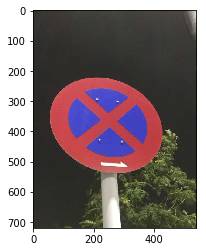

In [2]:
%matplotlib inline
# Import the image package
from PIL import Image
# we random selected one image in this csvfile, e.g, the 20th one
i = 20
# Use the image package to load the raw image with index i
im = Image.open('Data/img/{}'.format(csvfile['img'][i]))
# Print the image size (check the width and height in csv file)
print ("The image size is", im.size)
# Show the image
from matplotlib import pyplot as plt
plt.figure()
plt.imshow(im)

我們需要的是交通的標識，我們可以根據csv文件提供的座標把這個圖片裏面的標識框出來，如下圖：

What we need is the traffic sign, so the background is useless. We can mark this traffic sign by ROI:

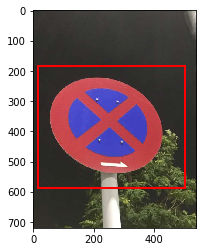

In [3]:
# Load the pathes package
from matplotlib import patches
# Get the coordinates for the ROI
x1 = csvfile['x1'][i]
x2 = csvfile['x2'][i]
y1 = csvfile['y1'][i]
y2 = csvfile['y2'][i]
# Python define a rectangle by setting the lower left point as the start point, and applies the width and height.
# So we need to get the start point coordinate, the width and the height.
x_lowerleft = x1
y_lowerleft = y2
width = x2-x1
height = y1-y2
# Use patches to draw a rectangle in specific location, with red border.
rect = patches.Rectangle((x_lowerleft, y_lowerleft), width, height, linewidth=2, edgecolor='red',facecolor='none')
# Show the image
plt.figure()
plt.imshow(im)
# Add the rectangle into the image
ax = plt.gca()
ax.add_patch(rect)

同樣我們可以把框起來的ROI部分提取出來用(Pillow包裏面Image的crop功能)：

Also, we can crop the image, only retains the ROI:

The traffic sign size is: (487, 404)


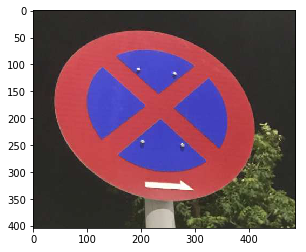

In [4]:
# Use the coordinate to crop the image, (left, upper, right, lower)
TrafficSign = im.crop((x1, y1, x2, y2))
# Print the cropped image size
print ("The traffic sign size is:", TrafficSign.size)
# Show the cropped image
plt.figure()
plt.imshow(TrafficSign)

我們依次把所有的原始圖片裏面對應的ROI提取出來就可以形成我們的訓練數據了。

但是現在有個新問題：每一個圖片的ROI對應的大小不一致。
所以我們可以改變所有提取出來的ROI的尺寸，比如，全部縮放成 100 $\times$ 100 的:

We can extract corresponding ROIs of all the raw images to form the training data.

But there is a new problem: the ROI may not in the same size!
So we can resize the ROI to a fixed size, for example, 100 $\times$ 100:

In [5]:
# Resize the ROI
TrafficSign = TrafficSign.resize((100, 100), Image.ANTIALIAS)
# Print the resized ROI size
print ("The resized traffic sign size is:", TrafficSign.size)

The resized traffic sign size is: (100, 100)


這樣我們對單張圖片的處理就完成了！

Now we have done the processing for the single image!

## 處理訓練數據
## Training Data Processing

現在我們開始正式生成我們的訓練數據。

大體思路如下：
+ 獲取所有圖片的名字，對應的ROI區域座標和標籤
+ 提取所有ROI區域
+ 將所有的ROI圖片拉平然後組成數據集

我們先開始第一步， 獲取所有的名字，座標以及標籤：

Now we can prepare to form our training data.

There are four steps for this processing:
+ Get names, ROI coordinates and labels of all the raw images
+ Extract all the ROIs
+ Flatten the ROIs and then form the training set

Let's start the first step:

In [8]:
# Get all names, locs and labels
# Name dataframe
ImgName_DF = csvfile['img']
# Coordinates dataframe
X1_DF = csvfile['x1']
X2_DF = csvfile['x2']
Y1_DF = csvfile['y1']
Y2_DF = csvfile['y2']
# Label dataframe
RawLabel = csvfile['class']

下面我們用for循環把所有的ROI區域提取出來，並且順帶拉平：

We can use the for loop to extract all the ROIs, and then flatten them.

In [21]:
# Get sample number
SampleNum = len(ImgName_DF)

# Generate a container for the final dataset
FinalData = np.zeros((SampleNum, 30000))
# Loop for the process of each image
for i in range(SampleNum):
    # Get corresponding name    
    imname = ImgName_DF[i]
    # Get corresponding coordinates    
    x1 = X1_DF[i]
    x2 = X2_DF[i]
    y1 = Y1_DF[i]
    y2 = Y2_DF[i]
    # load image, RGB
    img = Image.open('Data/img/{}'.format(imname)).convert("RGB")
    # crop the image
    sign = img.crop((x1, y1, x2, y2))
    # resize the cropped sign
    sign = sign.resize((100, 100), Image.ANTIALIAS)
    # flatten the sign
    signArr = np.asarray(sign).flatten()
    # put the flatten sign into the final dataset in ndarray format
    FinalData[i, :] = signArr

這樣我們就生成了訓練數據集了。

下面我們看看原始的標籤：

Now we get the final training data.

Let's see the un-processed label:

In [17]:
print ("The length of the raw label is", len(RawLabel))
print ("The unique label number is", len(np.unique(RawLabel.tolist())))
# Show the first 7 rows in label
print (RawLabel.head(7))
FinalLabel = RawLabel.tolist()

The length of the raw label is 370
The unique label number is 43
0    11
1    16
2    30
3    18
4    16
5    35
6    42
Name: class, dtype: int64


一共43个类别。
現在我們可以進行機器學習了。

下面我們開始機器學期部分：
+ 標準化數據集
+ 創建訓練集和測試集
+ 訓練一個模型
+ 評估模型的性能以及預測

首先我們來標準化數據集：

There are totally 43 classes! Now we can use machine learning method for our data:
+ Standardize our data
+ Split the data into training set and testing set
+ Use the training set to train a model
+ Evaluate the model

First we standardize our data:

In [18]:
# Load the scale package
from sklearn.preprocessing import scale
# Standardize the data
X_scaled = scale(FinalData)

然後我們來分隔訓練測試集：

Then we split the total data:

In [19]:
# Load the train_test_split package
from sklearn.model_selection import train_test_split
# Split the total data, 33%of which is regarded as the testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, FinalLabel,\
                                                   test_size=0.33, random_state=42)

接下來就是訓練模型：

Then training a model. E.g., Random Forest

In [20]:
# Load the Random Forest model
from sklearn.ensemble import RandomForestClassifier as rf
# Load the GridSearchCV model for optimization
from sklearn.model_selection import GridSearchCV

# Instantiate the random forest model
rfclf = rf(random_state=42)
# Set the parameters of the random forest for searching
rfparams = {'n_estimators': [10,20,30,50,100,200,500,1000],
            'max_features': [10, 20, 50, 100]}

# Instantiate a grid search with cross validation model to optimize the random forest model with the parameters
clf = GridSearchCV(rfclf, rfparams, n_jobs=-1, cv=5, verbose=1)
# Use the training set to fit the model
clf.fit(X_train, y_train)

# Show the best results
print ("The best model params is", clf.best_params_)
print ("The score of the best model is", clf.best_score_)

# Get the best estimator
bestclf = clf.best_estimator_
# Use the best estimator to predict
y_pred = bestclf.predict(X_test)
print ("The predicted label is", y_pred)
# Calculate the accuracy 
from sklearn.metrics import accuracy_score
print ("The accuracy for this model is", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  2.2min finished
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The best model params is {'max_features': 20, 'n_estimators': 100}
The score of the best model is 0.5222672064777328
The predicted label is [118  51 108  40  16  34  16  41  51  51 101  16  41 104  71  68  34  16
  34 118 108  40  68  51  41  40  41  41  41  16  16  51 118  51  51  41
  69  51  71  51  51  15 105  41 102  41  16  69  16 101 102  40  51  16
  51 102 101  34  40  69  34  16  16  69  16  40 118  34  51  41  51  51
  50  51  16  51  16  41 118  35  68  69  41  51  41  16  51  16 101  41
  50  69  41  41  51  35  50  41  16  51  40  51  43  50  51 102 118  16
  40 118  16  51  51  41 104  16  51  51  51  41  51  41  34]
The accuracy for this model is 0.4634146341463415
